In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
import os
import itertools
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Any day plots

## Baseline plots

In [ ]:
import plotly.express as px
res_dir = '/home/jptalusan/mta_stationing_problem/models/any_day/variable_timewindow'
fp = os.path.join(res_dir, f"any_day_tw_30", '2022-09-11_baseline_raw_results.pkl')
bl_df = pd.read_pickle(fp)


# Rename duplicate columns
cols=pd.Series(bl_df.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
bl_df.columns = cols
bl_df = bl_df.rename({"y_pred":"y_pred_load", "y_pred.1":"y_pred"}, axis=1)

bl_df['y_error'] = abs(bl_df['y_true'] - bl_df['y_pred']).astype('int')
bl_df = bl_df.groupby(['time_window', 'past', 'y_error']).count().reset_index()
fig = px.bar(bl_df, x="time_window", y="y_true", color="y_error", facet_col='past')
fig.show()


In [ ]:
res_dir = '/home/jptalusan/mta_stationing_problem/models/any_day/variable_timewindow'
time_windows = [1, 5, 10, 20, 30, 40, 50, 60, 120]
time_window = 30

In [ ]:
for tw in time_windows:
    fp = os.path.join(res_dir, f"any_day_tw_{tw}", '2022-09-10_evaluation_results_df.pkl')
    df = pd.read_pickle(fp)
    kfold = 0
    df = df.query("kfold == @kfold")
    df['y_error'] = abs(df['y_true'] - df['y_pred'])
    df = df.groupby(['y_error', 'time_window']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_direction':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
    df = pd.pivot_table(data=df, index=['time_window'], columns=['y_error'], values='count').fillna(0)
    
    fp = os.path.join(res_dir, f"any_day_tw_{tw}", '2022-09-11_baseline_raw_results.pkl')
    bl_df = pd.read_pickle(fp)
    
    # Rename duplicate columns
    cols=pd.Series(bl_df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    bl_df.columns = cols
    bl_df = bl_df.rename({"y_pred":"y_pred_load", "y_pred.1":"y_pred"}, axis=1)

    past = 1
    bl_df = bl_df.query("past == @past")
    bl_df['y_error'] = abs(bl_df['y_true'] - bl_df['y_pred']).astype('int')
    bl_df = bl_df.groupby(['y_error', 'time_window']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_direction':'first', 'y_pred_load':'count'}).rename({'y_pred_load':'count'}, axis=1).reset_index()
    bl_df = pd.pivot_table(data=bl_df, index=['time_window'], columns=['y_error'], values='count').fillna(0)
    
    fig, ax = plt.subplots(figsize=(15, 5), ncols=2, sharey=True, sharex=True)
    
    df.plot.bar(stacked=True, ax=ax[1], rot=0)
    bl_df.plot.bar(stacked=True, ax=ax[0], rot=0)
    bars = [thing for thing in ax[0].containers if isinstance(thing,mpl.container.BarContainer)]
    patterns = itertools.cycle(('-', '+', 'x', '\\', '*', 'o', 'O', '.'))
    d = {}
    for bar in bars:
        for patch in bar:
            pat = d.setdefault(patch.get_facecolor(), next(patterns))
            # patch.set_hatch(pat)
    # L = ax[0].legend()
    ax[0].get_legend().remove()
    
    # xticks = ax[0].get_xticklabels()
    # time_strs = []
    # for xtick in xticks:
    #     try:
    #         val = int(xtick.get_text())
    #     except:
    #         continue
    #     hour = val // (60 // 30)
    #     minute = 0
    #     if val % 2:
    #         minute = 30
    #     time_str = f"{str(hour).zfill(2)}:{str(minute).zfill(2)}"
    #     time_strs.append(time_str)
    # time_strs = list(zip(time_strs[0:], time_strs[1:]))
    # time_strs.append(('23:30', '00:00'))
    # time_strs.append(('23:30', '00:00'))
    # time_strs = [f"{ts[0]}-{ts[1]}" for ts in time_strs]
    # ax[0].set_xticklabels(time_strs)
    
    loc = ticker.MultipleLocator(base=15.0) # this locator puts ticks at regular intervals
    ax[0].xaxis.set_major_locator(loc)
    ax[1].xaxis.set_major_locator(loc)
    ax[0].set_ylabel('count')
    ax[0].set_xlabel('time windows')
    ax[1].set_xlabel('time windows')
    ax[0].set_title('Baseline')
    ax[1].set_title('Model')
    
    fp = os.path.join(res_dir, f"any_day_tw_{tw}", f'{tw}_compareplot.png') 
    plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
kfold = 0

fp = os.path.join('../evaluation', 'any_day_012_raw_results.pkl')
any_df = pd.read_pickle(fp)
any_df = any_df.query("kfold == @kfold")
any_df['y_error'] = abs(any_df['y_true'] - any_df['y_pred'])
any_df['count'] = 1
any_df = any_df.groupby(['y_error', 'time_window']).sum().reset_index()
any_df = pd.pivot_table(data=any_df, index=['time_window'], columns=['y_error'], values='count').fillna(0)

fp = os.path.join('../evaluation', 'day_ahead_012_raw_results.pkl')
day_df = pd.read_pickle(fp)
day_df = day_df.query("kfold == @kfold")
day_df['y_error'] = abs(day_df['y_true'] - day_df['y_pred'])
day_df['count'] = 1
day_df = day_df.groupby(['y_error', 'time_window']).sum().reset_index()
day_df = pd.pivot_table(data=day_df, index=['time_window'], columns=['y_error'], values='count').fillna(0)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2, sharey=True, sharex=True)
    
day_df.plot.bar(stacked=True, ax=ax[1], rot=0)
any_df.plot.bar(stacked=True, ax=ax[0], rot=0)
ax[0].legend().remove()
xticks = ax[0].get_xticklabels()
time_strs = []
for xtick in xticks:
    try:
        val = int(xtick.get_text())
    except:
        continue
    hour = val // (60 // 30)
    minute = 0
    if val % 2:
        minute = 30
    time_str = f"{str(hour).zfill(2)}:{str(minute).zfill(2)}"
    time_strs.append(time_str)
time_strs = list(zip(time_strs[0:], time_strs[1:]))
time_strs.append(('23:30', '00:00'))
time_strs = [f"{ts[0]}-{ts[1]}" for ts in time_strs]
ax[0].set_xticklabels(time_strs)

loc = ticker.MultipleLocator(base=15.0) # this locator puts ticks at regular intervals
ax[0].xaxis.set_major_locator(loc)
ax[1].xaxis.set_major_locator(loc)
ax[0].set_ylabel('count')
ax[0].set_xlabel('time windows')
ax[1].set_xlabel('time windows')
ax[0].set_title('Any Day')
ax[1].set_title('Day Ahead')

fp = '../plots/day_vs_any.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

# Same day plots

In [ ]:
res_dir = '/home/jptalusan/mta_stationing_problem/evaluation/same_day/clean_evaluation'
# time_windows = [1, 5, 10, 20, 30, 40, 50, 60, 120]
time_window = 15

In [ ]:
for tw in [time_window]:
    fp = os.path.join(res_dir, f"timewindow{tw}", 'results_5000_df.pkl')
    df = pd.read_pickle(fp)
    # kfold = 0
    df = df.query("y_pred != -1")
    df['y_error'] = abs(df['y_class'] - df['y_pred']).astype('int')
    df = df.groupby(['y_error', 'stop_sequence']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_dir':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
    df = df[df["stop_sequence"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])]
    df = pd.pivot_table(data=df, index=['stop_sequence'], columns=['y_error'], values='count').fillna(0)
    # display(df)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    df.plot.bar(stacked=True, ax=ax[1], rot=0)
    ax[1].set_xlabel('stop sequence')
    # ax[1].set_ylabel('count')
    ax[1].set_title('Model')
    # fp = os.path.join(res_dir, f"timewindow{tw}", f'sameday_count_error_plot.png') 
    # plt.savefig(fp, dpi=200, bbox_inches='tight')
    
    fp = os.path.join(res_dir, f"timewindow{tw}", 'baseline_5000.pkl')
    df = pd.read_pickle(fp)
    # kfold = 0
    df = df.query("y_pred_roll != -1").dropna()
    df['y_roll_error'] = abs(df['y_class'] - df['y_pred_roll']).astype('int')
    df['y_mean_error'] = abs(df['y_class'] - df['y_pred_mean']).astype('int')
    df['y_max_error'] = abs(df['y_class'] - df['y_pred_max']).astype('int')
    df = df.groupby(['y_mean_error', 'stop_sequence']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_dir':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
    df = df[df["stop_sequence"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])]
    df = pd.pivot_table(data=df, index=['stop_sequence'], columns=['y_mean_error'], values='count').fillna(0)
    # # display(df)
    df.plot.bar(stacked=True, ax=ax[0], rot=0)
    ax[0].legend().remove()
    ax[0].set_xlabel('stop sequence')
    ax[0].set_ylabel('count')
    ax[0].set_title('Baseline mean')
    fp = os.path.join(res_dir, f"timewindow{tw}", f'sameday_count_error_compare_baseline.png') 
    plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
month_label_dict = {11:'Nov', 12:'Dec', 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'}
for tw in [time_window]:
    fp = os.path.join(res_dir, f"timewindow{tw}", 'results_5000_df.pkl')
    df = pd.read_pickle(fp)
    # kfold = 0
    df = df.query("y_pred != -1")
    df['y_error'] = abs(df['y_class'] - df['y_pred']).astype('int')
    df = df.groupby(['y_error', 'stop_sequence', 'month']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_dir':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
    df = df[df["stop_sequence"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])]
    df = pd.pivot_table(data=df, index=['month', 'stop_sequence'], columns=['y_error'], values='count').fillna(0).reset_index()
    # df.unstack(1).plot(kind='bar', subplots=True, stacked=True, rot=0)
    # display(df[df['month']==11])
    fig, axes = plt.subplots(2,3,figsize=(10,5), sharex=True, sharey=True)
    axes = axes.flatten()

    loc = ticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
    for month, ax in zip([11, 12, 1, 2, 3, 4],axes):
        df[df['month']==month][['stop_sequence', 0, 1, 2]].set_index('stop_sequence').plot.bar(stacked=True, rot=0, ax=ax, )
        ax.get_legend().remove()
        ax.set_title(f"{month_label_dict[month]}")
        ax.xaxis.set_major_locator(loc)
        ax.set_xlabel('stop sequence')
    axes[0].legend()

fp = os.path.join(res_dir, f"timewindow{tw}", f'sameday_count_error_plot_monthly.png') 
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
_train = [1]
_test = [1, 2]
_val = [1]
if (len(_train) == 0) or (len(_test) == 0) or (len(_val) == 0):
    print("YES")

## Confusion matrix

In [ ]:
## Separate mean and max from baseline
fp = '/home/jptalusan/mta_stationing_problem/evaluation/same_day/clean_evaluation/timewindow15/results_5000_df.pkl'
df_lstm = pd.read_pickle(fp)
df_lstm = df_lstm.query("y_pred > -1")

fp = '/home/jptalusan/mta_stationing_problem/evaluation/same_day/clean_evaluation/timewindow15/baseline_5000.pkl'
df_baseline = pd.read_pickle(fp)
df_baseline = df_baseline.query("y_pred_max > -1").dropna(subset=['y_pred_mean'])

In [ ]:
df_lstm.head()

In [ ]:
df_baseline.head()

In [ ]:
os.getcwd()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# labels = [(0.0, 6.0), (7.0, 12.0), (13.0, 55.0), (56.0, 75.0), (76.0, 100.0)]
labels = ["0-6", "7-10", "13-55", "56-75", "76-100"]

ConfusionMatrixDisplay.from_predictions(df_lstm.groupby('trip_id').first()['y_class'], df_lstm.groupby('trip_id').first()['y_pred'], values_format = 'd', display_labels=labels)
plt.savefig('../plots/simple_lstm_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_baseline.groupby('trip_id').first()['y_class'], df_baseline.groupby('trip_id').first()['y_pred_max'], values_format = 'd', display_labels=labels)
plt.savefig('../plots/baseline_max_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_baseline.groupby('trip_id').first()['y_class'], df_baseline.groupby('trip_id').first()['y_pred_mean'], values_format = 'd', display_labels=labels)
plt.savefig('../plots/baseline_mean_lstm_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_baseline.groupby('trip_id').first()['y_class'], df_baseline.groupby('trip_id').first()['y_pred_roll'], values_format = 'd', display_labels=labels)
plt.savefig('../plots/baseline_roll_first_CM.png', dpi=200, bbox_inches='tight')

In [ ]:
fp = '/home/jptalusan/mta_stationing_problem/evaluation/same_day/clean_evaluation/new_simple_baseline_multi_stop_5P_xF_results_school_break.pkl'
df = pd.read_pickle(fp)
for k, v in df.iterrows():
    print(k)
    display(v.to_frame().T)
    break

# Plotting APC data status and noise

In [ ]:
fp = '/home/jptalusan/mta_stationing_problem/data/processed/matched_raw_manual_check.pkl'
mcd_df = pd.read_pickle(fp)

In [ ]:
mcd_df['load_diff'] = mcd_df['load'] - mcd_df['apc_load']

In [ ]:
mcd_df.query("remark == 'clean'").sort_values(by=['scheduled_time'])

In [ ]:
load_diff = mcd_df.query("remark == 'clean'").sort_values(by=['scheduled_time']).load_diff.to_numpy()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(load_diff)
ax.set_xlabel('Stops across time')
ax.set_ylabel('Diff. of Recorded APC\ndata from Ground Truth')
fp = '../plots/noisy_APC.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
mcd_df['count'] = 1
mcd_df['month'] = mcd_df['scheduled_time'].dt.month
mcd_df['year'] = mcd_df['scheduled_time'].dt.year
all_trips = mcd_df.groupby(['trip_id', 'transit_date']).agg({'month':'first', 'year':'first','count':'first', 'remark':pd.Series.mode})
all_trips = mcd_df.groupby(['remark', 'month', 'year']).sum().reset_index()
# all_trips = pd.pivot_table(data=mcd_df, index=['transit_date'], columns=['remark'], values='count')
# all_trips = all_trips.fillna(0)
# fig, ax = plt.subplots(figsize=(10, 5))
# all_trips.plot.bar(stacked=True, ax=ax, rot=0)

In [ ]:
all_trips = pd.pivot_table(data=all_trips, index=['year', 'month'], columns=['remark'], values='count').fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
all_trips.plot.bar(stacked=True, ax=ax, rot=0)

In [ ]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()
        
# /home/jptalusan/mta_stationing_problem/data/apc/complete-with-remark-wego-daily.apc.parquet
f = os.path.join('../data', 'apc', 'complete-with-remark-wego-daily.apc.parquet')
apcdata = spark.read.load(f)
apcdata.createOrReplaceTempView("apc")
# filter subset
query = f"""
SELECT trip_id, 
       transit_date,
       year,
       remark
FROM apc
WHERE (transit_date >= '2020-01-01') AND (transit_date <= '2022-04-06')
"""
# print(query)

apcdata = spark.sql(query)

In [ ]:
df = apcdata.toPandas()

In [ ]:
from copy import deepcopy
remarks_df = deepcopy(df)
remarks_df['count'] = 1
remarks_df['month'] = remarks_df['transit_date'].dt.month
# remarks_df = remarks_df.groupby(['trip_id', 'transit_date']).agg({'month':'first', 'year':'first','count':'first', 'remark':pd.Series.mode})
remarks_df = remarks_df.groupby(['trip_id', 'transit_date']).first()
remarks_df = remarks_df.groupby(['remark', 'month', 'year']).sum().reset_index()

In [ ]:
p_remarks_df = pd.pivot_table(data=remarks_df, index=['year', 'month'], columns=['remark'], values='count').fillna(0)
p_remarks_df = p_remarks_df[['clean', 'arrival_time_all_null', 'duplicates', 'load_lt_-5', 'offs_all_null', 'offs_on_error_gt_0.2', 'sync_issues']]
fig, ax = plt.subplots(figsize=(15, 5))
p_remarks_df.plot.bar(stacked=True, ax=ax, rot=0, color=['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17'], edgecolor='black')

loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.set_ylabel('counts')
fp = '../plots/clean_vs_bad.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')


In [ ]:
monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
a = p_remarks_df.reset_index(level=[0,1])
a['month_str'] = a['month'].apply(lambda x: monthDict[x])

# Plot comparisons

y_error,0.0,1.0,2.0,3.0,4.0,sum,per_correct
model,,,,,,,
BASE,58644.0,48629.0,18512.0,165.0,20.0,125970.0,0.465539
LSTM,29704.0,17741.0,3044.0,19.0,3.0,50511.0,0.588070
MLP,60302.0,38159.0,11567.0,17.0,1.0,110046.0,0.547971
RF,63185.0,38684.0,8157.0,20.0,0.0,110046.0,0.574169
XGB,62193.0,38649.0,9191.0,10.0,3.0,110046.0,0.565155


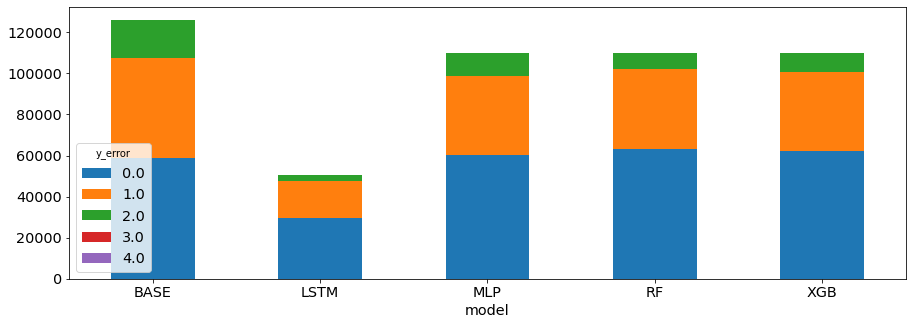

In [223]:
fp = os.path.join('../evaluation', 'any_day_comparisons', 'RF_raw_results.pkl')
rf_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'XGB_raw_results.pkl')
xgb_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'MLP_raw_results.pkl')
mlp_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'LSTM_raw_results.pkl')
lstm_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'BASELINE_raw_results.pkl')
baseline_results = pd.read_pickle(fp)

# Rename duplicate columns
cols=pd.Series(baseline_results.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
baseline_results.columns = cols
baseline_results = baseline_results.rename({"y_pred":"y_pred_load", "y_pred.1":"y_pred"}, axis=1)
kfold = 0
past = 1
n_lstm_units = 256
xgb_results.kfold.unique()
rf_results = rf_results.query("kfold == @kfold")
xgb_results = xgb_results.query("kfold == 1")
mlp_results = mlp_results.query("kfold == @kfold")
lstm_results = lstm_results.query("n_lstm_units == @n_lstm_units")
baseline_results = baseline_results.query("past == @past")

rf_results['y_error']        = abs(rf_results['y_true'] - rf_results['y_pred'])
xgb_results['y_error']       = abs(xgb_results['y_true'] - xgb_results['y_pred'])
mlp_results['y_error']       = abs(mlp_results['y_true'] - mlp_results['y_pred'])
lstm_results['y_error']      = abs(lstm_results['y_true'] - lstm_results['y_pred'])
baseline_results['y_error']  = abs(baseline_results['y_true'] - baseline_results['y_pred'])
rf_results['model'] = 'RF'
xgb_results['model'] = 'XGB'
mlp_results['model'] = 'MLP'
lstm_results['model'] = 'LSTM'
baseline_results['model'] = 'BASE'
cols = ['model', 'y_error']
rf_results = rf_results[cols]
xgb_results = xgb_results[cols]
mlp_results = mlp_results[cols]
lstm_results = lstm_results[cols]
baseline_results = baseline_results[cols]
all_comparisons = pd.concat([rf_results, xgb_results, mlp_results, lstm_results, baseline_results])
all_comparisons['count'] = 1
all_comparisons = all_comparisons.groupby(['model', 'y_error']).sum().reset_index()
all_comparisons = pd.pivot_table(data=all_comparisons, index=['model'], columns=['y_error'], values='count').fillna(0)
fig, ax = plt.subplots(figsize=(15, 5))
all_comparisons.plot.bar(stacked=True, ax=ax, rot=0)
all_comparisons['sum'] = all_comparisons.sum(axis=1)
all_comparisons['per_correct'] = all_comparisons[0.0]/all_comparisons['sum']
all_comparisons

In [4]:
from sklearn.metrics import mean_squared_error

# Define evaluator, requires some time information (merge testX, testY and pred)
def generate_results_over_time_window(results_df_arr, grouper):
    mse_df = pd.DataFrame()
    for i, (k, v) in enumerate(results_df_arr.groupby(grouper)):
        tdf = v[['time_window', 'y_pred', 'y_true']].groupby('time_window').agg({'y_pred': list, 'y_true': list})
        tdf['mse'] = tdf.apply(lambda x: mean_squared_error(x.y_true, x.y_pred, squared=False), axis=1)
        mse_df[i] = tdf['mse']
    mse_df['min'] = mse_df.min(axis=1)
    mse_df['max'] = mse_df.max(axis=1)
    return mse_df

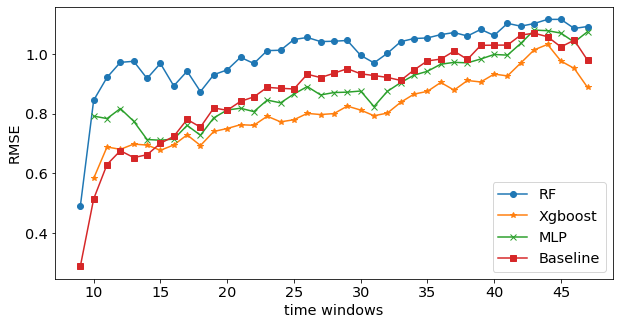

In [15]:
fp = os.path.join('../evaluation', 'any_day_comparisons', 'RF_raw_results.pkl')
rf_results = pd.read_pickle(fp)
mse_rf = generate_results_over_time_window(rf_results, 'kfold')

fp = os.path.join('../evaluation', 'any_day_comparisons', 'XGB_raw_results.pkl')
xgb_results = pd.read_pickle(fp)
mse_xgb = generate_results_over_time_window(xgb_results, 'kfold')

fp = os.path.join('../evaluation', 'any_day_comparisons', 'MLP_raw_results.pkl')
mlp_results = pd.read_pickle(fp)
mse_mlp = generate_results_over_time_window(mlp_results, 'kfold')

fp = os.path.join('../evaluation', 'any_day_comparisons', 'LSTM_raw_results.pkl')
lstm_results = pd.read_pickle(fp)
mse_lstm = generate_results_over_time_window(lstm_results, 'n_lstm_units')

fp = os.path.join('../evaluation', 'any_day_comparisons', 'BASELINE_raw_results.pkl')
baseline_results = pd.read_pickle(fp)
# Rename duplicate columns
cols=pd.Series(baseline_results.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
baseline_results.columns = cols
baseline_results = baseline_results.rename({"y_pred":"y_pred_load", "y_pred.1":"y_pred"}, axis=1)
mse_baseline = generate_results_over_time_window(baseline_results, 'past')

fig, ax = plt.subplots(figsize=(10, 5))
mse_rf[4:].plot(y='min', ax=ax, marker='o', label='RF')
mse_xgb[4:].plot(y='min', ax=ax, marker='*', label='Xgboost')
mse_mlp[4:].plot(y='max', ax=ax, marker='x', label='MLP')
# mse_lstm[4:].plot(y='min', ax=ax, marker='^', label='LSTM')
mse_baseline[4:].plot(y='min', ax=ax, marker='s', label='Baseline')

ax.set_ylabel('RMSE')
ax.set_xlabel('time windows')
fp = '../plots/comparisons_triplevel.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
fp = os.path.join('../evaluation', 'any_day_comparisons', 'RF_raw_results.pkl')
rf_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'XGB_raw_results.pkl')
xgb_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'MLP_raw_results.pkl')
mlp_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'LSTM_raw_results.pkl')
lstm_results = pd.read_pickle(fp)

fp = os.path.join('../evaluation', 'any_day_comparisons', 'BASELINE_raw_results.pkl')
baseline_results = pd.read_pickle(fp)

# Rename duplicate columns
cols=pd.Series(baseline_results.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
baseline_results.columns = cols
baseline_results = baseline_results.rename({"y_pred":"y_pred_load", "y_pred.1":"y_pred"}, axis=1)

In [ ]:
kfold = 0
past = 1
n_lstm_units = 256

In [ ]:
xgb_results.kfold.unique()

In [ ]:
rf_results = rf_results.query("kfold == @kfold")
xgb_results = xgb_results.query("kfold == 1")
mlp_results = mlp_results.query("kfold == @kfold")
lstm_results = lstm_results.query("n_lstm_units == @n_lstm_units")
baseline_results = baseline_results.query("past == @past")

rf_results['y_error']        = abs(rf_results['y_true'] - rf_results['y_pred'])
xgb_results['y_error']       = abs(xgb_results['y_true'] - xgb_results['y_pred'])
mlp_results['y_error']       = abs(mlp_results['y_true'] - mlp_results['y_pred'])
lstm_results['y_error']      = abs(lstm_results['y_true'] - lstm_results['y_pred'])
baseline_results['y_error']  = abs(baseline_results['y_true'] - baseline_results['y_pred'])

In [ ]:
rf_results['model'] = 'RF'
xgb_results['model'] = 'XGB'
mlp_results['model'] = 'MLP'
lstm_results['model'] = 'LSTM'
baseline_results['model'] = 'BASE'
cols = ['model', 'y_error']
rf_results = rf_results[cols]
xgb_results = xgb_results[cols]
mlp_results = mlp_results[cols]
lstm_results = lstm_results[cols]
baseline_results = baseline_results[cols]

In [ ]:
all_comparisons = pd.concat([rf_results, xgb_results, mlp_results, lstm_results, baseline_results])
all_comparisons['count'] = 1

In [ ]:
all_comparisons = all_comparisons.groupby(['model', 'y_error']).sum().reset_index()
all_comparisons = pd.pivot_table(data=all_comparisons, index=['model'], columns=['y_error'], values='count').fillna(0)
fig, ax = plt.subplots(figsize=(15, 5))
all_comparisons.plot.bar(stacked=True, ax=ax, rot=0)

In [ ]:
all_comparisons['sum'] = all_comparisons.sum(axis=1)

In [ ]:
all_comparisons['per_correct'] = all_comparisons[0.0]/all_comparisons['sum']

In [ ]:
all_comparisons